# Graph Theoretical Analysis of data collected during EPM experiment on DRD73

In [1]:
# Bring your packages onto the path
import os
import sys
sys.path.append(os.path.abspath(os.path.join("..", "..")))

import pandas as pd
import networkx as nx
import numpy as np
import seaborn as sns
from analysis.sig_proc import Deconvoluter
from analysis.graph_analysis_utils import NeuronNetwork
from analysis.analysis_utils import FeatureExtractor
from analysis.resampling import Resampler
from scipy import stats
from IPython.core.interactiveshell import InteractiveShell

In [2]:
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

In [3]:
mouse_directory = os.path.join(os.path.expanduser("~"), "Hen_Lab/Mice/EPM")

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, os.path.join(dir_name, file_name)))
            file_num += 1
            raw_files.append(os.path.join(dir_name, file_name))

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM2_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM2_drd87.csv
3. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
4. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
5. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
6. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
7. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
8. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [4]:
drd73_raw_data = pd.read_csv(raw_files[3], header=None)
drd73_raw_data = FeatureExtractor.downsample_dataframe(drd73_raw_data, 2)
deconvoluter = Deconvoluter(drd73_raw_data)

beh_cols = [
    "Trial_time", "Recording_time", "X_center", "Y_center", "Area", "Areachange", "Elongation", "Distance_moved", "Velocity", "Arena_centerpoint", 
    "Open1_centerpoint", "Open2_centerpoint", "Closed1_centerpoint", "Closed2_centerpoint", "OpenArms_centerpoint", "ClosedArms_centerpoint", "Result_1"
]

behavior_df = pd.read_csv(raw_files[4], header=None)
drd73 = FeatureExtractor(cell_transients_df=deconvoluter.cell_transients, auc_df=deconvoluter.cell_auc_df, behavior_df=behavior_df, behavior_col_names=beh_cols)

# Only leave the neuron numbers to save space when plotting the networks
drd73.auc_df.columns = [col+1 for col in drd73.auc_df.columns]

/Users/saveliyyusufov/Hen_Lab/analysis/analysis_utils.py:29: Warning:

Row multiple to downsample behavior dataframe not specified. Behavior dataframe will be downsampled by a row multiple of 3



In [5]:
def get_behavior_graph(feature_extractor, behavior):   
    indices = feature_extractor.neuron_concated_behavior.loc[feature_extractor.neuron_concated_behavior[behavior] != 0].index
    graph = NeuronNetwork(feature_extractor.auc_df.iloc[indices])
    return graph

### We plot the network of neurons that were imaged in DRD73, for the *entire* duration of the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


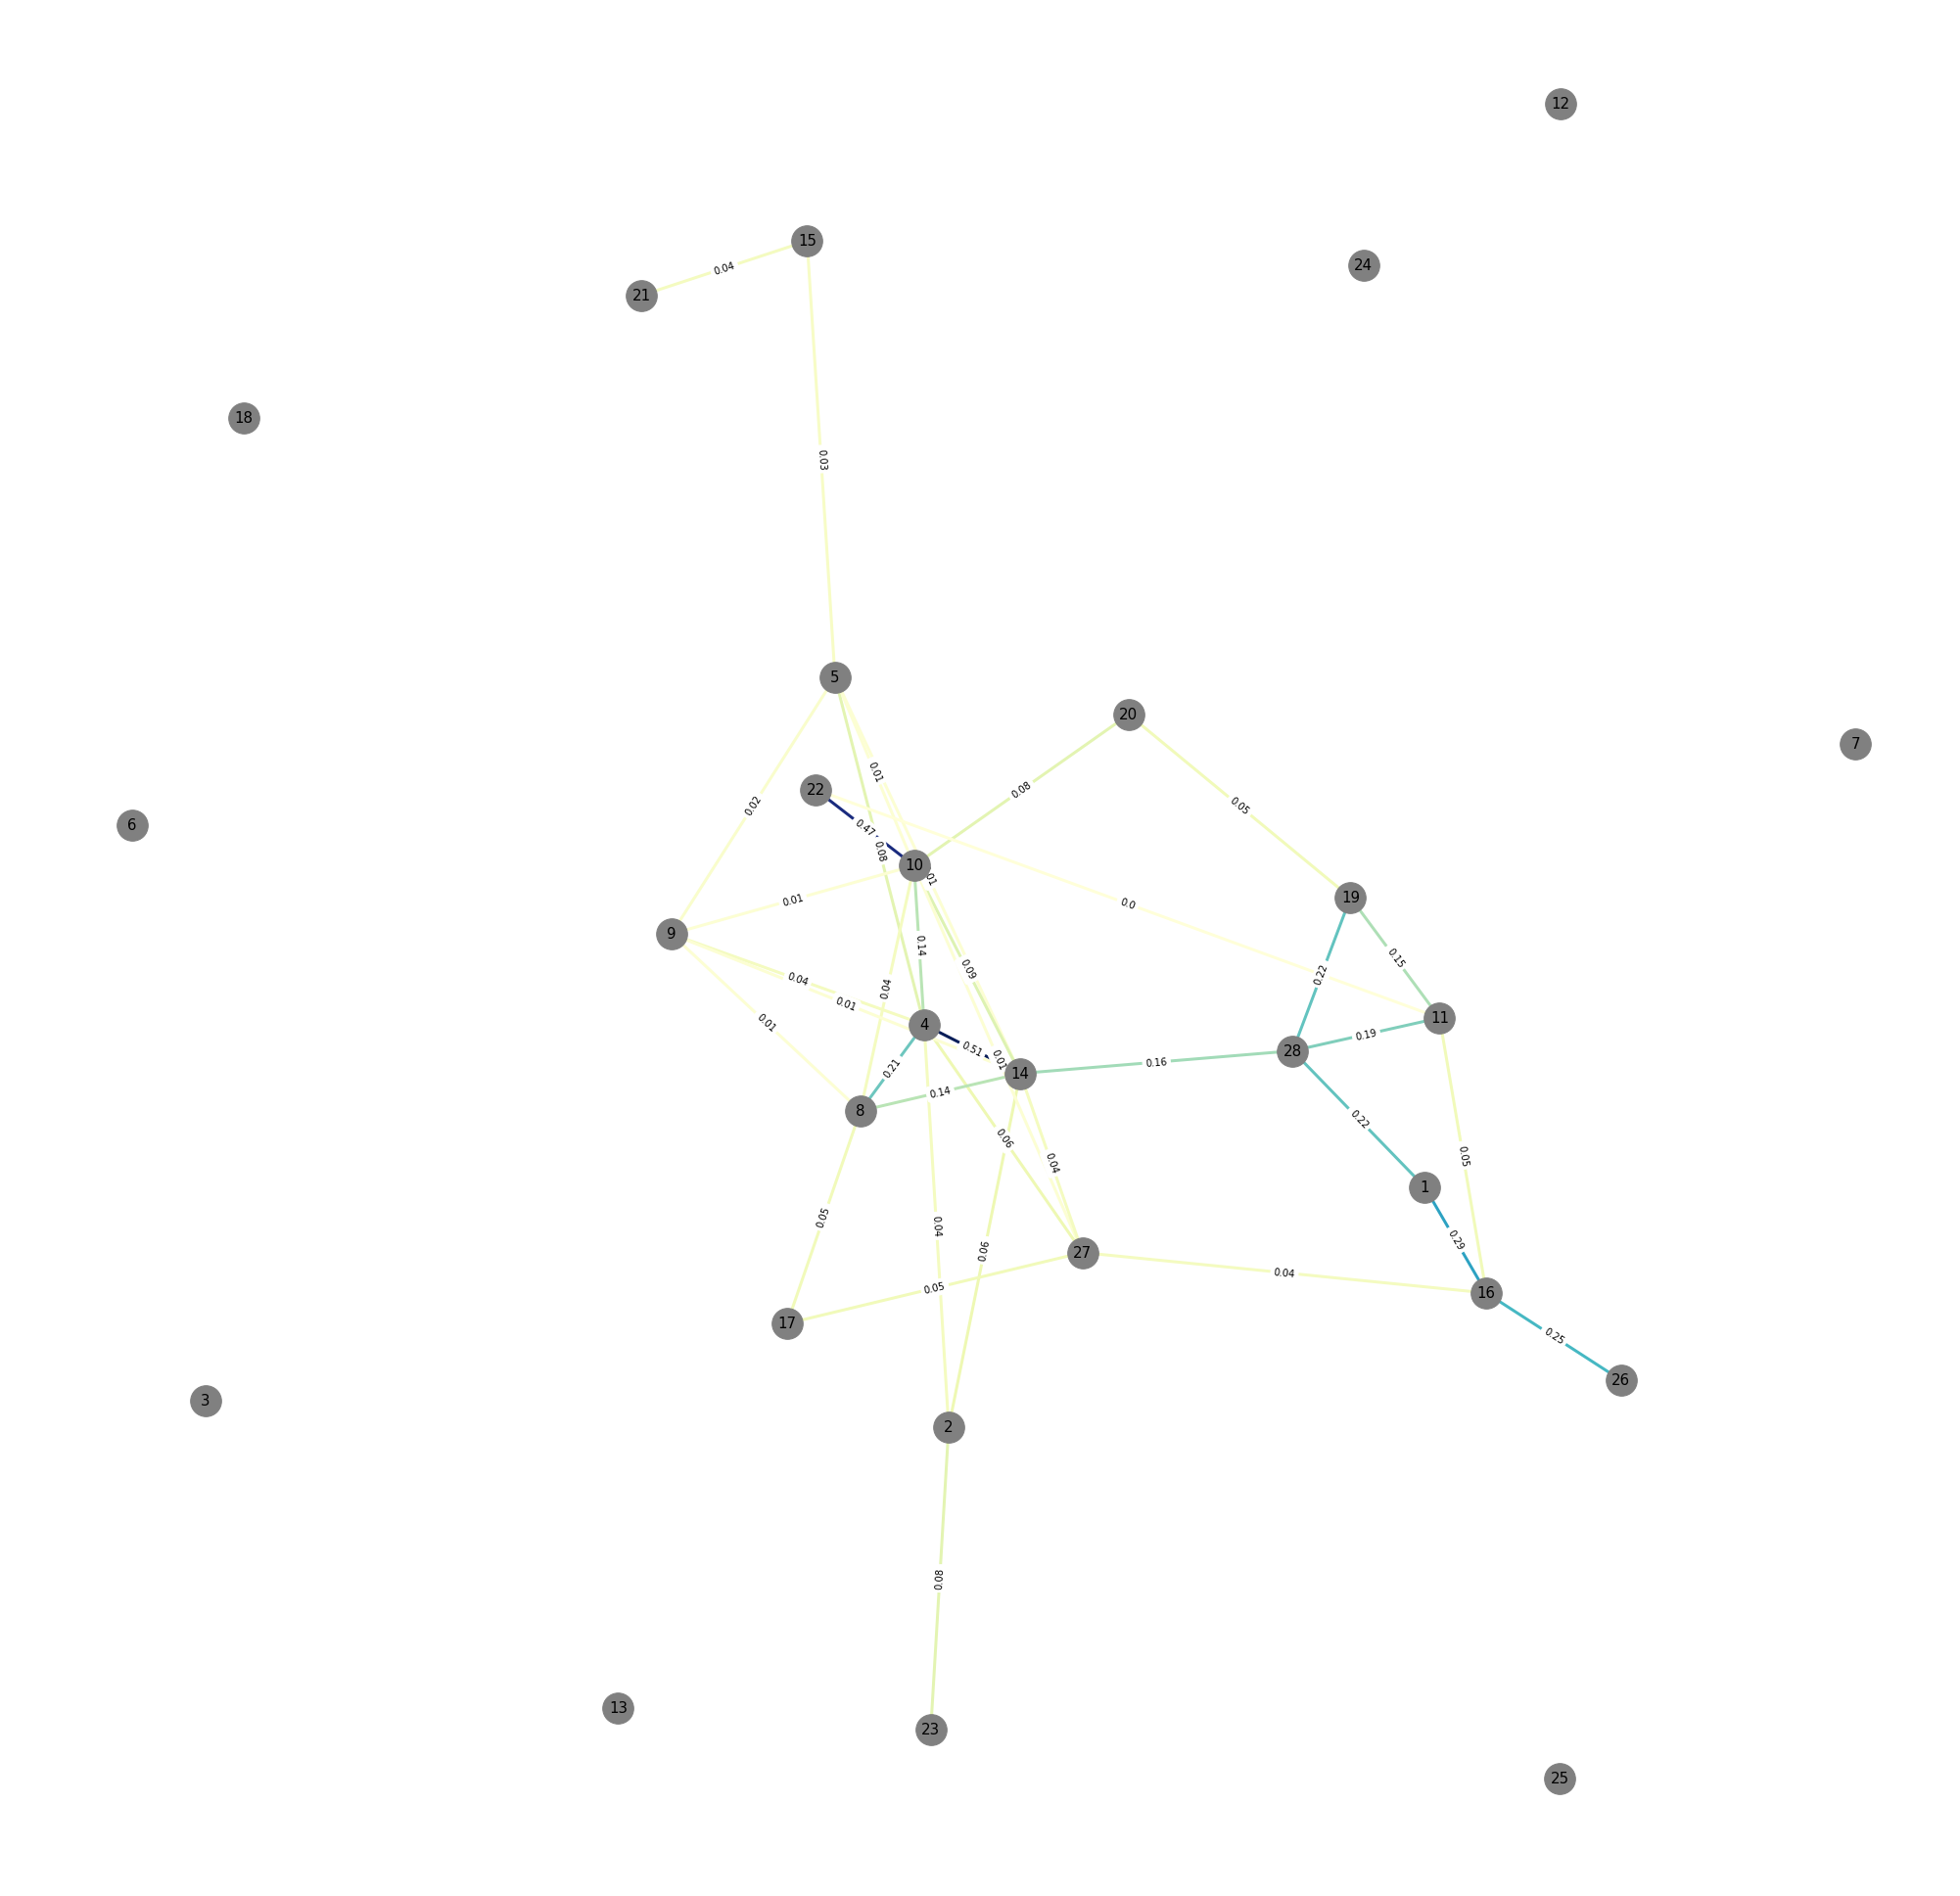

In [6]:
drd73_total_graph = NeuronNetwork(drd73.auc_df)
drd73_total_graph.plot(node_color="grey", figsize=(35, 35), node_size=1000)

### Next, we plot the network of neurons that were imaged in DRD73, for the entire duration of time spent in the **OpenArms** during the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


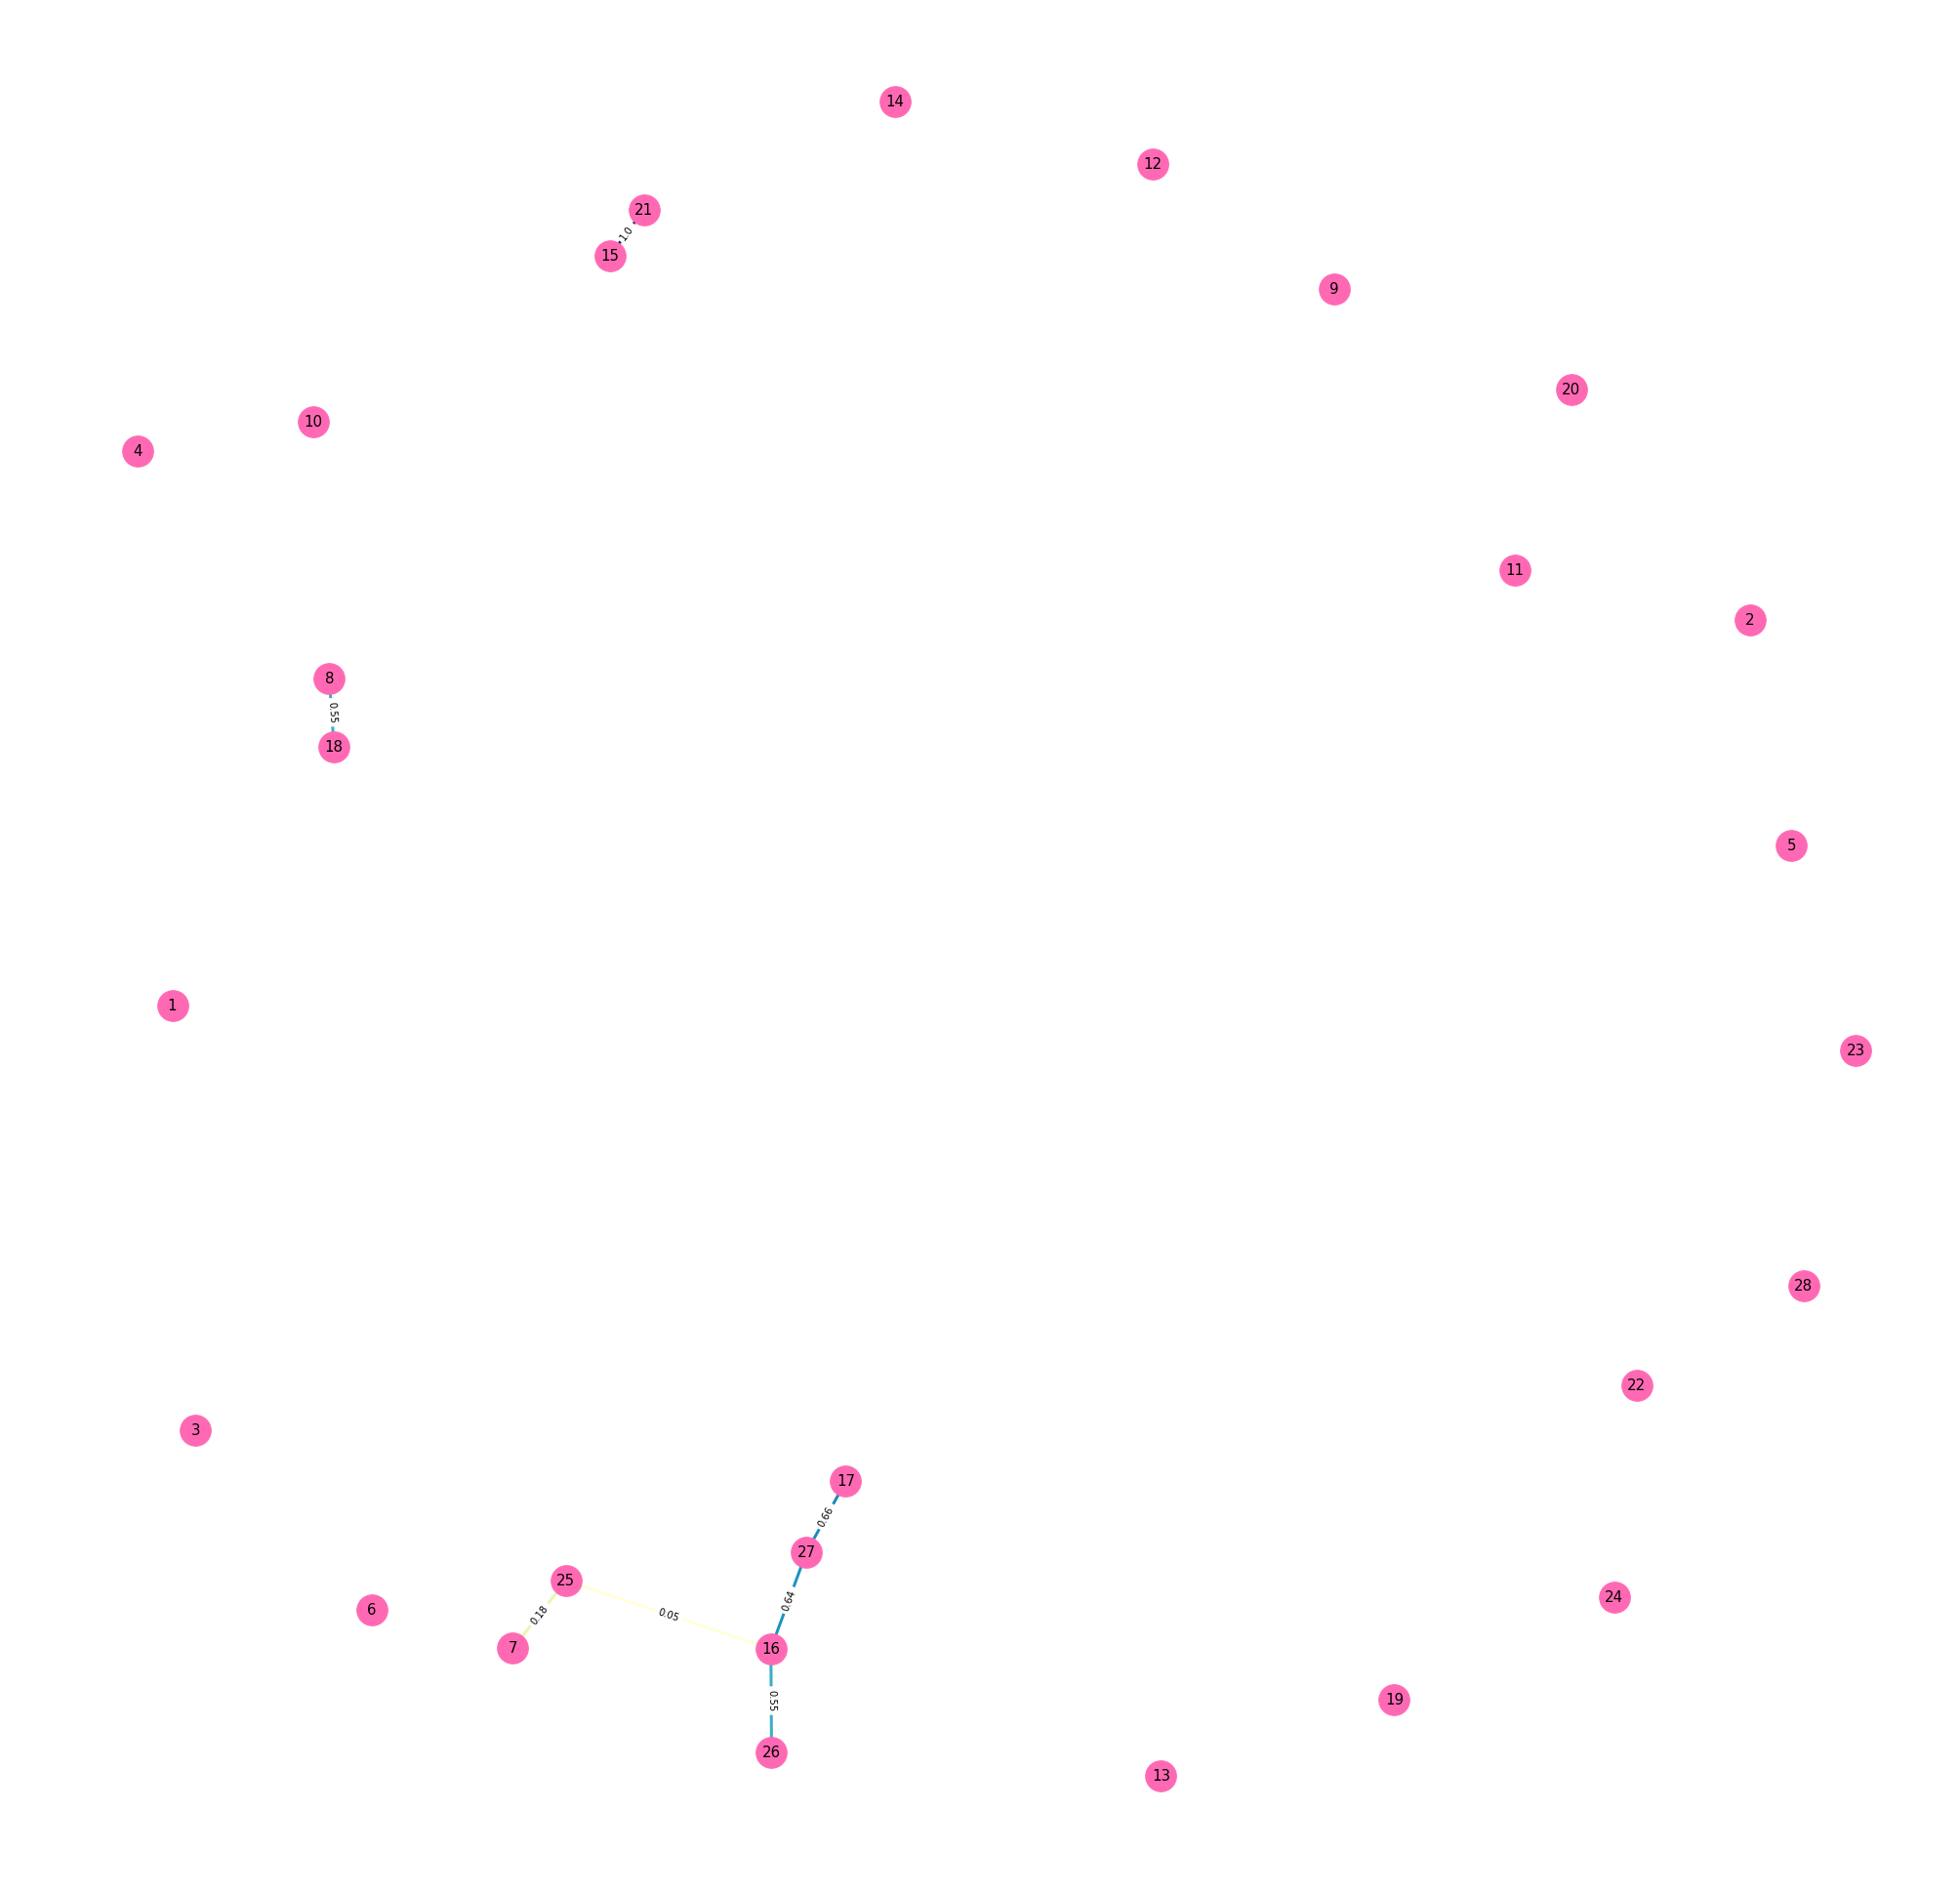

In [7]:
drd73_open_arms_graph = get_behavior_graph(drd73, "OpenArms_centerpoint")
drd73_open_arms_graph.plot(node_color="hotpink", figsize=(35, 35), node_size=1000)

### Finally, we plot the network of neurons that were imaged in DRD77, for the entire duration of time spent in the **ClosedArms** during the EPM experiment.

You did not provide a neuron position dictionary, so the Spring Layout algorithm will be used to plot the network


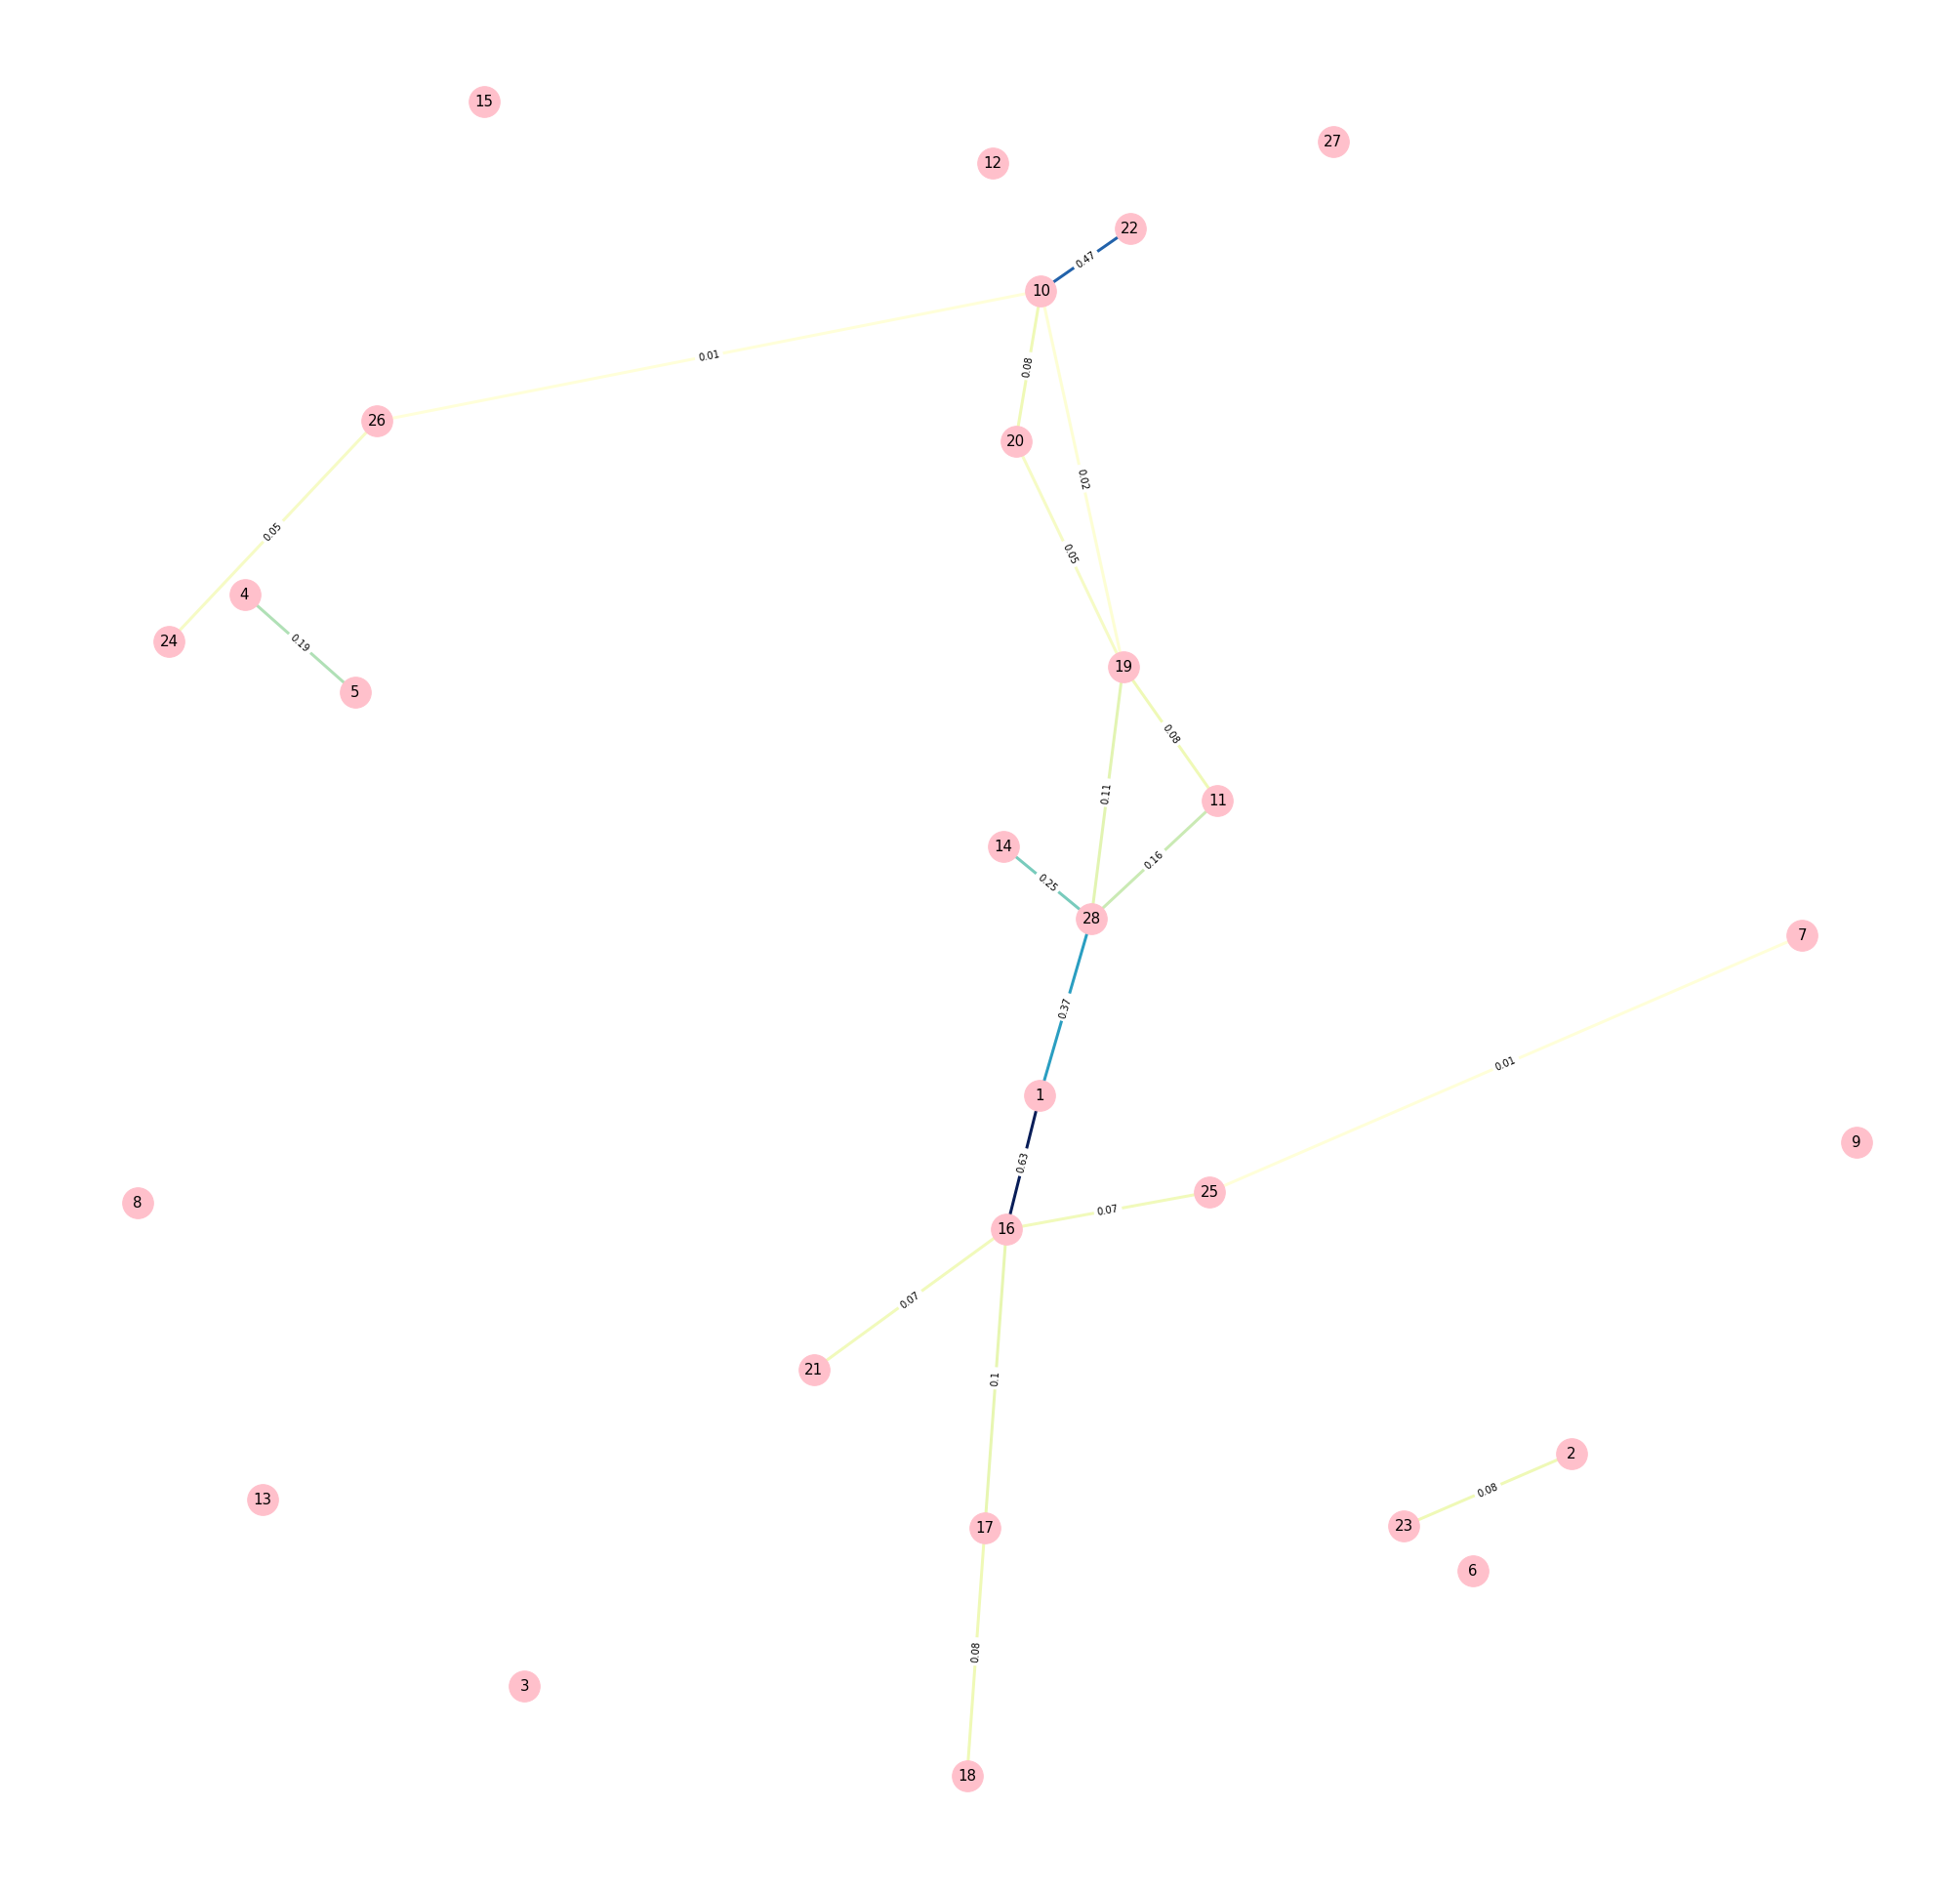

In [8]:
drd73_closed_arms_graph = get_behavior_graph(drd73, "ClosedArms_centerpoint")
drd73_closed_arms_graph.plot(node_color="pink", figsize=(35, 35), node_size=1000)

# Now we compute and plot all of the network measures (of interest), for each mouse.

In [9]:
import matplotlib.pylab as plt

def quick_bar_plot(y1, y2, **kwargs):
    figsize = kwargs.get("figsize", (6, 5))
    fig, ax = plt.subplots(figsize=figsize)

    index = np.arange(1)
    bar_width = 0.35
    opacity = 0.4
    rects1 = ax.bar(index, tuple(y1), bar_width, alpha=opacity, color='b', label="Open Arms")
    rects2 = ax.bar(index + bar_width, tuple(y2), bar_width, alpha=opacity, color='r', label="Closed Arms")

    # ax.set_xlabel("DRD87")
    ylabel = kwargs.get("ylabel", "Measure")
    ax.set_ylabel(ylabel)
    title = kwargs.get("title", "Title Goes Here")
    ax.set_title(title)
    ax.set_xticks([])
    ax.legend();
    fig.tight_layout();
    plt.show();

### *Hubs are nodes with high degree, or high centrality. The centrality of a node measures how many of the shortest paths between all other nodes pairs in the network pass through it. A node with high centrality is thus cruciail to efficinet communication.* (Bullmore and Sporns)

### We took take the mean of the degree centrality of all the nodes in the networks of interest. As we can see, the mean degree centrality of the networks is higher when the mice were in the open arms of the EPM.

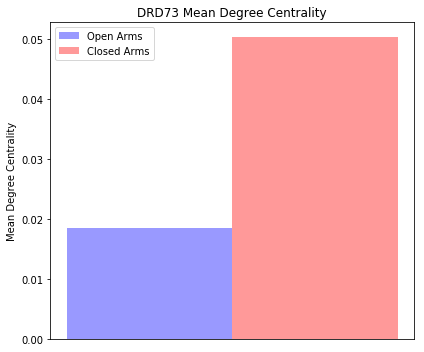

In [10]:
open_measures = [drd73_open_arms_graph.mean_degree_centrality] 
closed_measures = [drd73_closed_arms_graph.mean_degree_centrality]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Mean Degree Centrality", ylabel="Mean Degree Centrality", figsize=(6, 5))

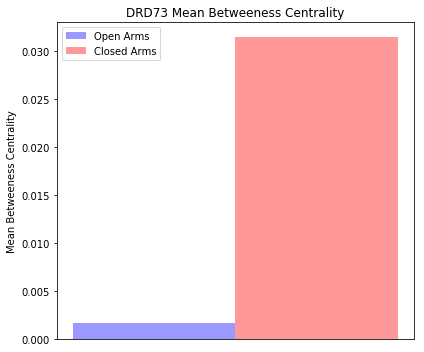

In [11]:
open_measures = [drd73_open_arms_graph.mean_betw_centrality] 
closed_measures = [drd73_closed_arms_graph.mean_betw_centrality]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Mean Betweeness Centrality", ylabel="Mean Betweeness Centrality", figsize=(6, 5))

### *Connection density is the actual number of edges in the graph as a proportion of the total number of possible edges and is the simplest estimator of the physical cost — for example, the energy or other resource requirements — of a network.* (Bullmore and Sporns)

### As one would expect, the connection density is greater when the mice were in the open arms of the EPM.

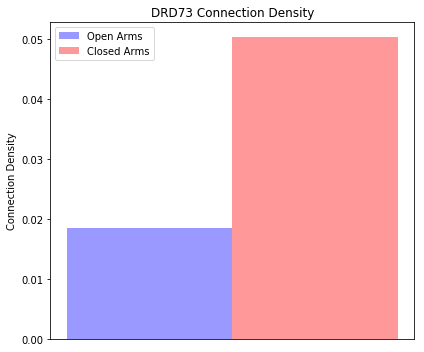

In [12]:
open_measures = [drd73_open_arms_graph.connection_density] 
closed_measures = [drd73_closed_arms_graph.connection_density]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Connection Density", ylabel="Connection Density", figsize=(6, 5))

### *If the nearest neighbors of a node are also directly connected to each other they form a cluster. The clustering coefficient quantifies the number of connections that exist between the nearest neighbors of a node as a proportion of the maximum number of possible connections. Random networks have lowe average clustering whereas complex networks have high clustering (associated with high local efficiency of information transfer and robustness).* (Bullmore and Sporns)

### As shown below, the clustering coefficient for all the networks was greater when the mice were in the open arms of the EPM.

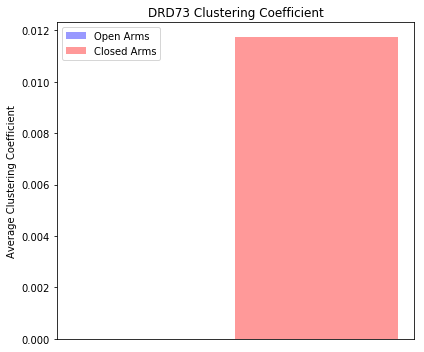

In [13]:
open_measures = [drd73_open_arms_graph.clustering_coefficient] 
closed_measures = [drd73_closed_arms_graph.clustering_coefficient]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Clustering Coefficient", ylabel="Average Clustering Coefficient", figsize=(6, 5))

### *The 'small-world' property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of a network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections - mostly within a clique of neighbours.* (Bullmore and Sporns)

### As shown below, we computed the mean clique size, as well as the maximum clique size, in all networks of interest. We observe that larger cliques of neurons were formed when the mice were in the open arms of the EPM.

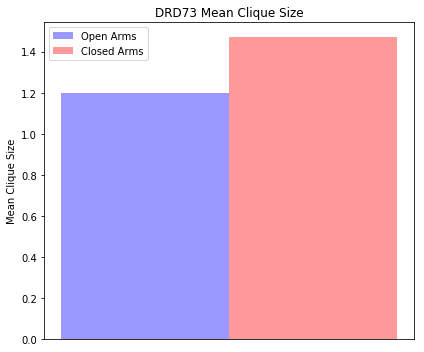

In [14]:
open_measures = [drd73_open_arms_graph.mean_clique_size] 
closed_measures = [drd73_closed_arms_graph.mean_clique_size]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Mean Clique Size", ylabel="Mean Clique Size", figsize=(6, 5))

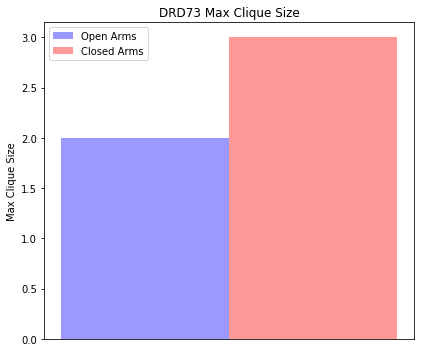

In [15]:
open_measures = [drd73_open_arms_graph.max_clique_size] 
closed_measures = [drd73_closed_arms_graph.max_clique_size]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Max Clique Size", ylabel="Max Clique Size", figsize=(6, 5))

### *Path length is the minimum number of edges that must be traversed to go from one node to another. Random and complex networks have short mean path lengths (high global efficiency of parallel information transfer) whereas regular lattices have long mean path lengths. Efficiency is inversely related to path length but is numerically easier to use to estimate topological distances between elements of disconnected graphs.* (Bullmore and Sporns)

### We compute the global efficiency of all networks of interest, and we find that global efficiency was greater when the mice were in the open arms of the EPM.

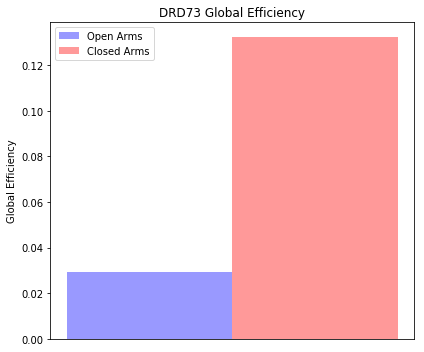

In [16]:
open_measures = [drd73_open_arms_graph.global_efficiency] 
closed_measures = [drd73_closed_arms_graph.global_efficiency]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Global Efficiency", ylabel="Global Efficiency", figsize=(6, 5))

#### Originally described in social networks, the ‘small-world’ property combines high levels of local clustering among nodes of a network (to form families or cliques) and short paths that globally link all nodes of the network. This means that all nodes of a large system are linked through relatively few intermediate steps, despite the fact that most nodes maintain only a few direct connections — mostly within a clique of neighbours. Small-world organization is intermediate between that of random networks, the short overall path length of which is associated with a low level of local clustering, and that of regular networks or lattices, the high-level of clustering of which is accompanied by a long path length. A convenient single-number summary of small-worldness is thus the ratio of the clustering coefficient to the path length after both metrics have been standardized by comparing their values to those in equivalent random networks (Bullmore and Sporns 2009).

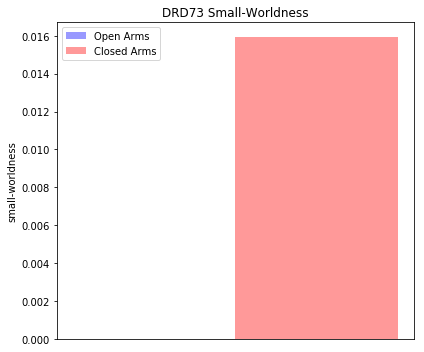

In [17]:
open_measures = [drd73_open_arms_graph.small_worldness] 
closed_measures = [drd73_closed_arms_graph.small_worldness]
quick_bar_plot(open_measures, closed_measures, title="DRD73 Small-Worldness", ylabel="small-worldness", figsize=(6, 5))